In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)#pd.reset_option(“max_columns”)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set_style('whitegrid')

# ---- Data Preparation ----
## 1. load raw data
(note: all datasets are saved in same directory '../data/...csv')

In [2]:
uva = pd.read_csv('../data/uva_merged.csv', low_memory=False)
print("shape: ", uva.shape)

shape:  (5124891, 141)


## 2. select columns
notation: _uva - raw column names

In [3]:
# select feature name respectively
info_uva = ['id', 'tsa']

demo_uva = ['age']

vital_uva = ['Temp',
             'Resp',
             'Pulse',
             'hr',
             'SBP',
             'DBP',
             'SpO2',
             'GCS',
             'FiO2',
             'O2.Flow'
             ]

lab_uva = ['GLUCOSE',
           'TOTAL.BILIRUBIN',
           'POTASSIUM',
           'ALBUMIN',
           'CALCIUM',
           'SODIUM',
           'WHITE.BLOOD.CELL.COUNT',
           'PHOSPHORUS',
           'PROTIME.INR',
           'CREATININE',
           'PLATELET.COUNT',
           'ALT.GPT',
           'CO2',
           'ALKALINE.PHOSPHATASE',
           'AST.GOT',
           'PCO2',
           'CHLORIDE',
           'TROPONIN.I',
           'PARTIAL.THROMBOPLASTIN.TIME',
           'LACTIC.ACID',
           'BLOOD.UREA.NITROGEN',
           'OXYGEN.SATURATION',
           'MAGNESIUM',
           'FIO2' ,
           's.rr', # sd of respiratory rate by chest impedance (breaths/min)
           's.edr', # sd of electrocardiogram-derived respiratory rate (breaths/min)
           'srr', # sd of the R-R interval by cardiac telemetry (s)
           's.hr', # sd of heart rate by cardiac telemetry (beats/min)
           'ds', # local dynamics density of heart rate
           'mrr', # mean R-R interval by cardiac telemetry (s)
           's.so2', # sd of oxygen saturation by pulse oximetry (%)
           'x.hr.edr',
           'x.hr.so2'
          ]


uva_X = info_uva + demo_uva + vital_uva + lab_uva
uva_y = ['GP','GN','fungus','mycobacteria','Confirmed Txp','True_positive']
df_org = uva.loc[:, uva_X + uva_y].copy()

## 3. rename columns

In [4]:
# make sure all '.' are replaced by '_'
df_org.columns = df_org.columns.str.replace(r".", "_")

# 4. fix outliers in data

In [5]:
df = df_org

# fix labs
df.loc[df['GLUCOSE']<49,['GLUCOSE']]=49
df.loc[df['GLUCOSE']>460,['GLUCOSE']]=460
df.loc[df['TOTAL_BILIRUBIN']>50,['TOTAL_BILIRUBIN']]=50
df.loc[df['POTASSIUM']>6.6,['POTASSIUM']]=6.6
df.loc[df['POTASSIUM']<2.4,['POTASSIUM']]=2.4
df.loc[df['ALBUMIN']>5,['ALBUMIN']]=5
df.loc[df['CALCIUM']>12,['CALCIUM']]=12
df.loc[df['CALCIUM']<6.1,['CALCIUM']]=6.1
df.loc[df['SODIUM']<119,['SODIUM']]=119
df.loc[df['SODIUM']>172,['SODIUM']]=172
df.loc[df['WHITE_BLOOD_CELL_COUNT']>33.85,['WHITE_BLOOD_CELL_COUNT']]=33.85
#df.loc[df['WHITE_BLOOD_CELL_COUNT']<2,['WHITE_BLOOD_CELL_COUNT']]=2
df.loc[df['PHOSPHORUS']>8,['PHOSPHORUS']]=8
df.loc[df['PROTIME_INR']>5,['PROTIME_INR']]=5
df.loc[df['CREATININE']>10,['CREATININE']]=10
df.loc[df['PLATELET_COUNT']>1001,['PLATELET_COUNT']]=1001
df.loc[df['ALT_GPT']>1085,['ALT_GPT']]=1085
df.loc[df['CO2']>40,['CO2']]=40
df.loc[df['ALKALINE_PHOSPHATASE']>800,['ALKALINE_PHOSPHATASE']]=800
df.loc[df['AST_GOT']>1203,['AST_GOT']]=1203
df.loc[df['PCO2']>100.5,['PCO2']]=100.5
df.loc[df['CHLORIDE']>132,['CHLORIDE']]=132
df.loc[df['CHLORIDE']<83,['CHLORIDE']]=83
df.loc[df['TROPONIN_I']>23.5,['TROPONIN_I']]=23.5
df.loc[df['PARTIAL_THROMBOPLASTIN_TIME']>140,['PARTIAL_THROMBOPLASTIN_TIME']]=140
df.loc[df['LACTIC_ACID']>19.1,['LACTIC_ACID']]=19.1
df.loc[df['BLOOD_UREA_NITROGEN']>143,['BLOOD_UREA_NITROGEN']]=143
df.loc[df['OXYGEN_SATURATION']<17.6,['OXYGEN_SATURATION']]=17.6
df.loc[df['MAGNESIUM']>3.4,['MAGNESIUM']]=3.4
df.loc[(df['FIO2']<21)|(df['FIO2'].isna()),['FIO2']]=21


# fix vitals
## temperature F to C
df.loc[df['Temp']>104, ['Temp']]=104
df.loc[df['Temp'].between(80,92), ['Temp']]=92
df.loc[df['Temp'].between(92,104),['Temp']] = df[df['Temp'].between(92,104)]['Temp'].apply(lambda x: (x-32)*5/9)
df.loc[df['Temp']<33.33333, ['Temp']]=33.33333
df.loc[df['Temp'].between(40,80), ['Temp']]=40
df.loc[df['Resp']>80,['Resp']]=80
df.loc[df['Resp']<5,['Resp']]=5
df.loc[df['Pulse']>300,['Pulse']]=300
df.loc[df['Pulse']<30,['Pulse']]=30
# heartrate
df.loc[df['hr']>300,['hr']]=300
df.loc[df['hr']<30,['hr']]=30
df.loc[df['SBP']>250,['SBP']]=250
df.loc[df['SBP']<40,['SBP']]=40
df.loc[df['DBP']>150,['DBP']]=150
df.loc[df['DBP']<26,['DBP']]=26
df.loc[df['SpO2']<79,['SpO2']]=79
#df.loc[df['GCS']<10,['GCS']]=10
df.loc[(df['FiO2']<21)|(df['FiO2'].isna()),['FiO2']]=21
df.loc[(df['O2_Flow']<0)|(df['O2_Flow'].isna()),['O2_Flow']]=0

df_fixed = df.copy()

# ---- Episode sequences ----
## 1. individual data imputation
Vital signs are kept for 24 hours. Labs are kept for 48 hours

In [6]:
def data_imputation(df):
    """
    data imputation on clinical features
    
    Inputs:
    df -- dataframe of ONE patient
    
    Outputs:
    df -- patient dataframe after imputation
    
    """
   
    info = ['id', 'tsa']

    demo = ['age']

    vital = ['Temp', 'Resp', 'Pulse','hr', 'SBP', 'DBP', 'SpO2','GCS', 'FiO2', 'O2_Flow']

    lab = ['GLUCOSE', 'TOTAL_BILIRUBIN', 'POTASSIUM',
           'ALBUMIN', 'CALCIUM', 'SODIUM', 'WHITE_BLOOD_CELL_COUNT', 'PHOSPHORUS',
           'PROTIME_INR', 'CREATININE', 'PLATELET_COUNT', 'ALT_GPT', 'CO2',
           'ALKALINE_PHOSPHATASE', 'AST_GOT', 'PCO2', 'CHLORIDE', 'TROPONIN_I',
           'PARTIAL_THROMBOPLASTIN_TIME', 'LACTIC_ACID', 'BLOOD_UREA_NITROGEN',
           'OXYGEN_SATURATION', 'MAGNESIUM', 'FIO2', 's_rr', 's_edr', 'srr',
           's_hr', 'ds', 'mrr', 's_so2', 'x_hr_edr','x_hr_so2']

    interpolation_cols = []
    median_cols = []
    
    
    try:
        df[vital] = df[vital].fillna(method='ffill',limit=24*4) 
        df[lab] = df[lab].fillna(method='ffill',limit=48*4) 
        df[interpolation_cols] = df[interpolation_cols].interpolate(limit_direction='both')
        df[median_cols] = df[median_cols].fillna(df[median_cols].median())   
        for col in demo:
            df[col] = df.loc[df[col].first_valid_index(), col]
    except:
        pass
    return df   

## 2. save episode sequences into 2D dataframe
- ep: episode
- B: before
- A: after
- imp: imputation
- org: original (no imputation)

In [7]:
def preprocess(df, patient_id, h_before=12, h_after=24, unit=15, imputation=True, test=False, each=False):
    
    """
    
    Inputs:
    df -- the original dataframe
    patient_id -- id of one patient in target group
    h_before -- how many hours BEFORE a positive/negative instance(default 12h)
    h_after -- how many hours AFTER a positive/negative instance(default 24h)
    unit -- how many minutes in a time unit(default 15mins)
    imputation -- whether or not fulfilling the gaps(default True)
    test -- whether or not testing function(default False)
    each_pos -- whether or not slice episode around each positive/negative instance(default False)
    
    Outputs:
    patient -- pre-processed dataframe for this patient
    
    """
    import missingno as msno
    
    # Subset single patient dataframe from original dataframe
    patient = df[df['id'] == patient_id]
    patient = patient.reset_index(drop=True)
    
    # Make patient dataframe one time unit per row
    ts = pd.DataFrame(range(int(patient['tsa'].iloc[0]),int(patient['tsa'].iloc[-1]),unit),columns=['ts'])
    patient = pd.merge(left=ts,right=patient,left_on='ts',right_on='tsa',how='left',copy = False)
    
    # Data imputation
    if test: msno.matrix(patient);       
    if imputation: patient = data_imputation(patient)
    if test: msno.matrix(patient);   
    
    # Slice episodes
    B = h_before*60/unit # #of time units before each positive instance
    A = h_after*60/unit # #of time units after each positive instance    
    
    ## for positive patients
    pos_idx = patient[patient['True_positive']==1].index.tolist() # positive indices
    neg_idx = patient[patient['True_positive']==0].index.tolist() # negative indices
    
    if test: 
        print(patient_id, "positive index:", pos_idx)
        print(patient_id, "negative index:", neg_idx)
    
    # positive patient    
    if len(pos_idx) > 0: 
        t_ep_list = [] 
        if each:# if we want to slice around every positive instance
            t_ep_list = pos_idx
        else: # only keep time indices at least max(A,B) units later than the last one
            t_ep = pos_idx[0] 
            t_ep_list.append(t_ep)
            for t in pos_idx:
                if t - t_ep > max(A,B):
                    t_ep = t
                    t_ep_list.append(t_ep)       
        
        episodes = pd.DataFrame()
        EP = 0        
        for t in t_ep_list:            
            EP += 1
            episode = patient.iloc[range(max(int(t-B), patient.index[0]),min(int(t+A), patient.index[-1])+1),:]
            episode_idx = list(range(int(t-B),int(t+A+1)))
            episode = episode.reindex(episode_idx, fill_value = np.nan)
            episode = episode.reset_index(drop=True)            
            ## 1. imputation on clinical features (or not)
            #if imputation: episode = data_imputation(episode)
            # 2. fulfill empty cells in patient id
            episode['id'] = patient_id
            # 3. save order of episode for this patient  
            episode['episode'] = EP
            # 4. save relative time within this episode/window:
            episode['relative_time'] = list(range(int(-B),int(A)+1))
            # 5. save BSI 
            episode['BSI'] = 1
            # 6. save infection type all 0 if given
            try:
                infection_list = ['GP','GN','fungus','mycobacteria']
                episode.loc[:,infection_list] = episode.loc[B, infection_list].values.astype(int) 
            except:
                pass
            episodes = pd.concat([episodes, episode])  # append to cases dataframe
            assert(episodes.shape[0]%(B+A+1)==0), "Error in patient"+str(patient_id)# if number of rows is not multiple of S+E+1, raise error
            
            
    # negative patient
    elif len(neg_idx) > 0: # using elif (not if) because we only consider all-time negative patients       
        assert(len(pos_idx) == 0)
        t_ep_list = [] 
        if each:# if we want to slice around every positive instance
            t_ep_list = neg_idx
        else: # only keep time indices at least max(A,B) units later than the last one
            t_ep = neg_idx[0] 
            t_ep_list.append(t_ep)
            for t in neg_idx:
                if t - t_ep > max(A,B):
                    t_ep = t
                    t_ep_list.append(t_ep)       
        
        episodes = pd.DataFrame()
        EP = 0        
        for t in t_ep_list:  
            EP += 1
            episode = patient.iloc[range(max(int(t-B), patient.index[0]),min(int(t+A), patient.index[-1])+1),:]
            episode_idx = list(range(int(t-B),int(t+A+1)))
            episode = episode.reindex(episode_idx, fill_value = np.nan)
            episode = episode.reset_index(drop=True)            
            ## 1. imputation on clinical features (or not)
            #if imputation: episode = data_imputation(episode)
            # 2. fulfill empty cells in patient id
            episode['id'] = patient_id
            # 3. save order of episode for this patient 
            episode['episode'] = EP
             # 4. save relative time within this episode/window:
            episode['relative_time'] = list(range(int(-B),int(A)+1))
            # 5. save BSI 
            episode['BSI'] = 0
            # 6. save infection type all 0 if given
            try:
                infection_list = ['GP','GN','fungus','mycobacteria']
                episode.loc[:,infection_list] = 0
            except:
                pass
            episodes = pd.concat([episodes, episode])  # append to cases dataframe
            assert(episodes.shape[0]%(B+A+1)==0), "Error in patient"+str(patient_id)# if number of rows is not multiple of S+E+1, raise error
           
        
    try:# Save transplant statues of this patient if given
        episodes['txp'] = 1 if 'yes' in patient['Confirmed Txp'].unique().tolist() else 0 # save transplant status
    except: 
        pass
    
    if test: msno.matrix(episodes);
    
    return episodes

#### testing case test # 7805

7805 positive index: [0, 153, 218, 314, 410, 602, 698, 794, 890, 986, 1082, 1178, 1274, 1366, 1462, 1558, 1654, 1750, 1846, 2518, 3439, 3505, 3670, 3695, 3705, 3730, 3766, 3800, 3883, 3958, 4236, 4293, 4367]
7805 negative index: [506, 1965, 2074, 2326, 2614]


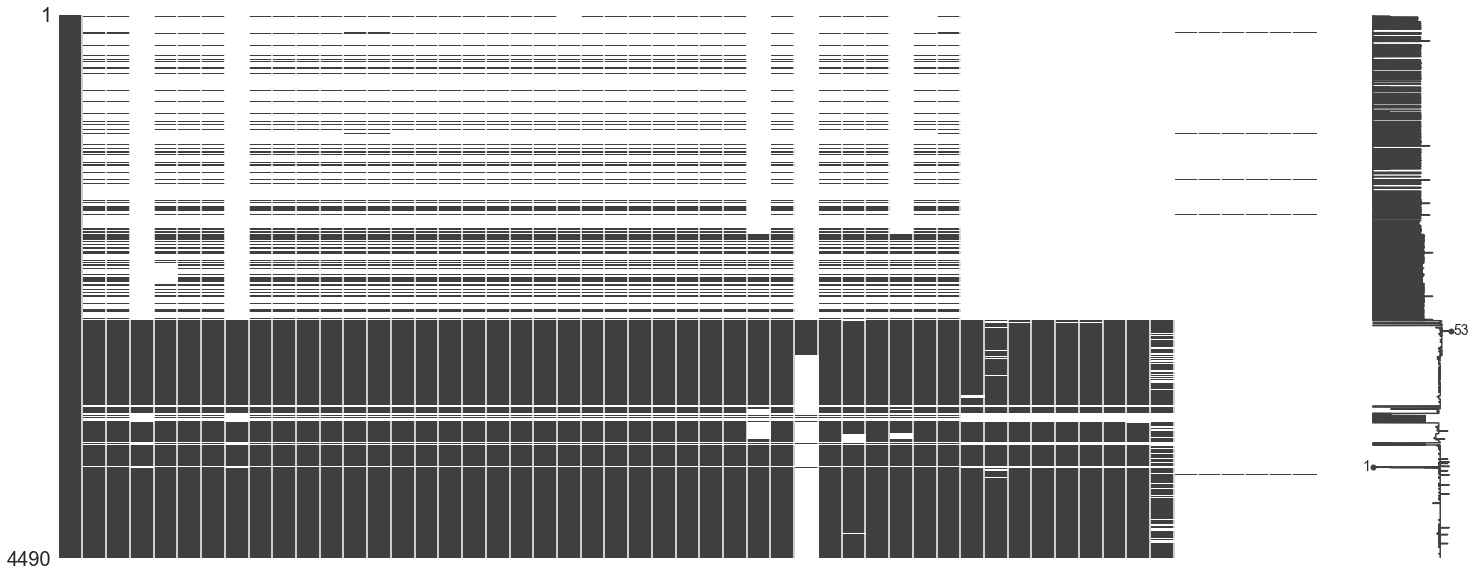

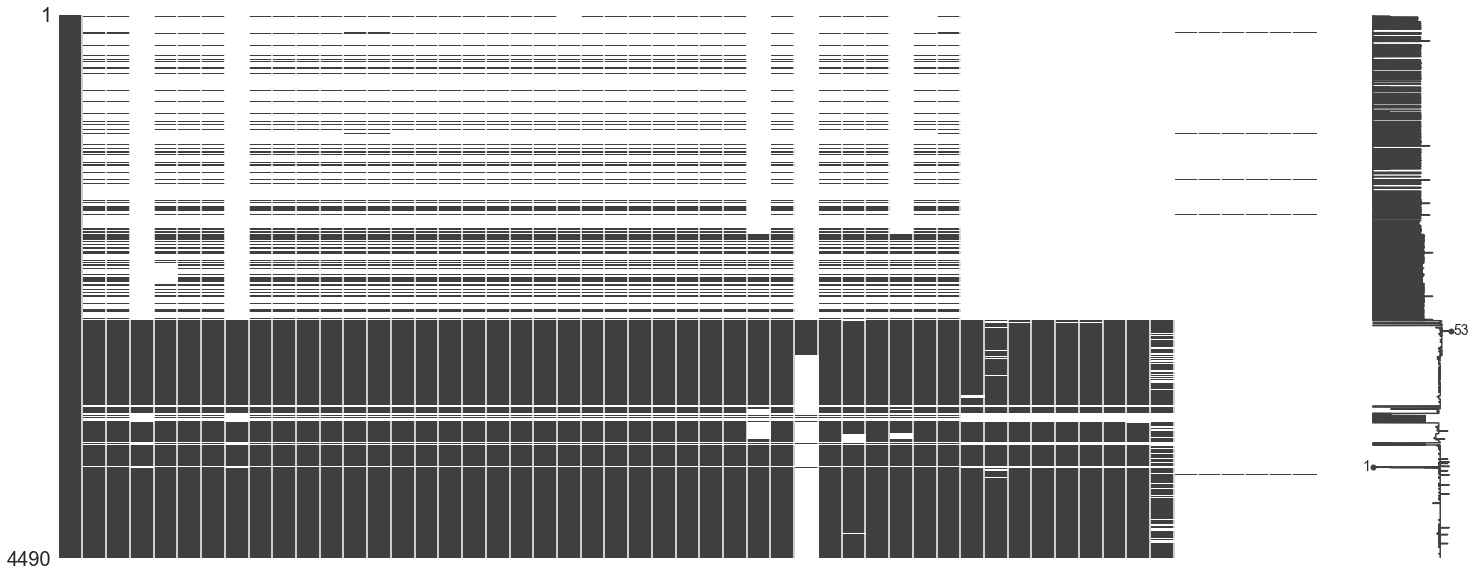

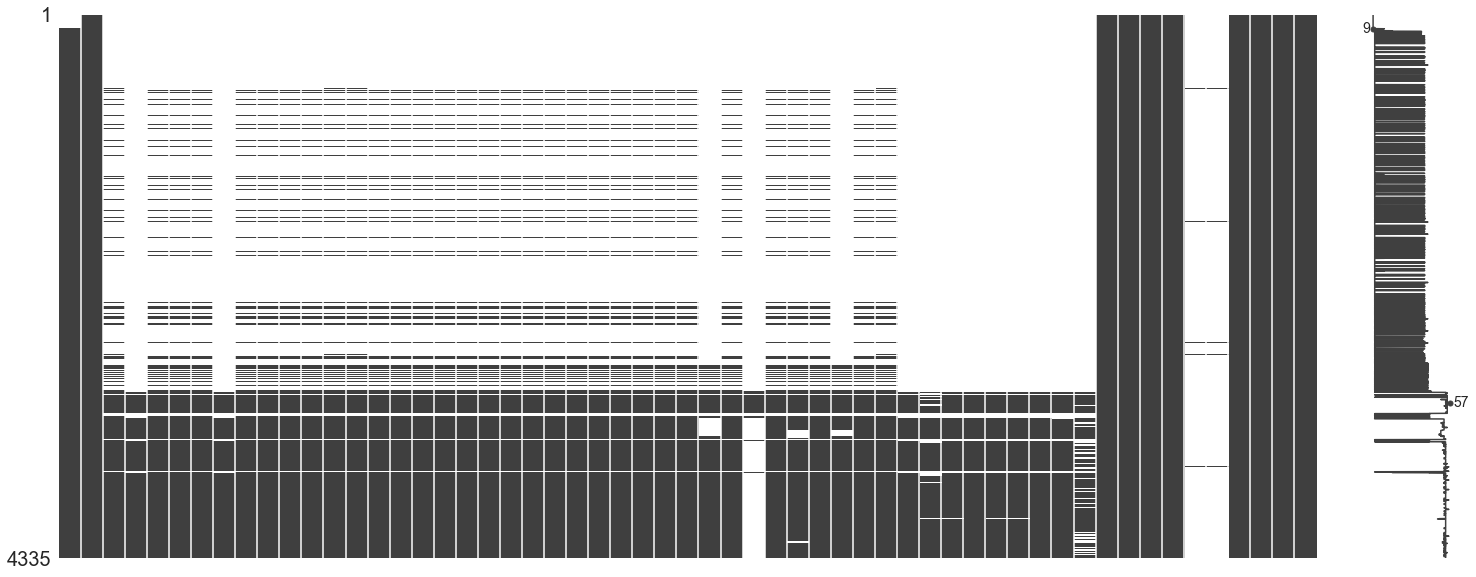

In [8]:
case = preprocess(df, 7805, h_before=1*24+4, h_after=2*24-4, test=True, imputation=False)

####  episode sequence

In [9]:
bco_id = list(set(uva['ID'].dropna().astype(int)))
ep = pd.DataFrame()
for patient_id in bco_id:
    patient_seq = preprocess(df, patient_id, h_before=1*24-5, h_after=2*24+5, imputation=False)
    ep = pd.concat([ep, patient_seq])
ep['relative_time']= ep['relative_time']-5*4
ep.to_csv('../data/ep_uva_1B2A_raw.csv', index = False)

## 3. save safe_zone window for control group

In [10]:
def slice_safe_zone(df,feas, patient_id, h_before=7*24-5, h_after=7*24+5, unit=15, ep_len=48, imputation=True, zone=False):

    info = ['id','tsa','Confirmed Txp','True_positive']
    
    patient = df[df['id'] == patient_id][info+feas]
    patient = patient.reset_index(drop=True)

    # Make patient dataframe one time unit per row
    ts = pd.DataFrame(range(int(patient['tsa'].iloc[0]),int(patient['tsa'].iloc[-1]),unit),columns=['ts'])
    patient = pd.merge(left=ts,right=patient,left_on='ts',right_on='tsa',how='left',copy = False)
    
    # patient-wise data imputation
    if imputation: patient = data_imputation(patient)
    
    # Slice episodes
    B = h_before*60/unit # #of time units before each positive instance
    A = h_after*60/unit # #of time units after each positive instance    
   
    # create a column for danger zone (infection episode) tag, set defualt value 0
    patient['tag'] = 0
    # get blood culture instance index
    ins_idx = patient[patient['True_positive'].isin([0,1])].index.tolist()
    # set tag of rows within danger zone as 1
    for t in ins_idx:
        patient.loc[range(max(int(t-B), patient.index[0]),min(int(t+A), patient.index[-1])+1),['tag']] = 1

    # get all safe zone data 
    safe_zone = pd.DataFrame()
    safe_zone = patient[patient['tag']==0].copy()
    
    # create empty result dataframe
    safe_df = pd.DataFrame()
    
    try:
    # if we want to keep all safe zone record
        if zone:
            # save not-completely-empty rows from safe zone
            safe_df = safe_zone[~safe_zone[feas].isnull().all(axis=1)]  
            print("get not-empty safe zone from patient", patient_id)
        else:
            idx = safe_zone[feas].count(axis=1).idxmax() # get index of the first row who contains most observations 
            #print("idxmax",idx)
            safe_window = safe_zone.loc[range(idx,min(int(idx+ep_len*60/unit+1), safe_zone.index[-1]+1)),:].copy()
            # 1. coerce safe_window to be episode-length
            safe_window = safe_window.reset_index(drop=True)
            safe_window = safe_window.reindex(list(range(0, int(ep_len*60/unit+1))))
            # 2. fulfill empty cells with personal safe_zone median
            safe_window[feas] = safe_window[feas].fillna(safe_zone[feas].median())
            # 3. save window to final safe_df
            safe_df = safe_window
            # print success
            print ("get safe window from patient", patient_id)
        # keep txp status
        safe_df['txp'] = 1 if 'yes' in patient['Confirmed Txp'].unique().tolist() else 0 # save transplant status
        assert(safe_df['txp'].notnull().all())
        # save patient id
        safe_df['id'] = patient_id
        assert(safe_df['id'].notnull().all())   
        
        # save mean and max baseline_df of feas for this patient 
        for f in feas:
            safe_df[f+'_mean'] = safe_zone[f].mean()
            safe_df[f+'_max'] = safe_zone[f].max()

        #print(safe_df)
    except:
            pass
    
    return safe_df

In [11]:
demo = ['age']
vital = ['Temp', 'Resp', 'Pulse','hr', 'SBP', 'DBP', 'SpO2','GCS', 'FiO2', 'O2_Flow']
lab = ['GLUCOSE', 'TOTAL_BILIRUBIN', 'POTASSIUM',
           'ALBUMIN', 'CALCIUM', 'SODIUM', 'WHITE_BLOOD_CELL_COUNT', 'PHOSPHORUS',
           'PROTIME_INR', 'CREATININE', 'PLATELET_COUNT', 'ALT_GPT', 'CO2',
           'ALKALINE_PHOSPHATASE', 'AST_GOT', 'PCO2', 'CHLORIDE', 'TROPONIN_I',
           'PARTIAL_THROMBOPLASTIN_TIME', 'LACTIC_ACID', 'BLOOD_UREA_NITROGEN',
           'OXYGEN_SATURATION', 'MAGNESIUM', 'FIO2', 's_rr', 's_edr', 'srr',
           's_hr', 'ds', 'mrr', 's_so2', 'x_hr_edr','x_hr_so2']




feas = demo + vital + lab
bco_id = list(set(uva['ID'].dropna().astype(int)))
safe_df = pd.DataFrame()
for patient_id in bco_id:
    safe_zone = slice_safe_zone(df_fixed,feas,patient_id, imputation=False)
    safe_df = pd.concat([safe_df, safe_zone])
safe_df.to_csv('../data/safe48_allvars_uva_raw.csv', index = False)

get safe window from patient 10
get safe window from patient 14
get safe window from patient 17
get safe window from patient 22
get safe window from patient 23
get safe window from patient 26
get safe window from patient 31


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


get safe window from patient 40
get safe window from patient 43
get safe window from patient 44
get safe window from patient 46
get safe window from patient 49
get safe window from patient 55
get safe window from patient 59
get safe window from patient 62
get safe window from patient 67
get safe window from patient 68
get safe window from patient 69
get safe window from patient 70
get safe window from patient 72
get safe window from patient 73
get safe window from patient 76
get safe window from patient 77
get safe window from patient 79
get safe window from patient 81
get safe window from patient 83
get safe window from patient 86
get safe window from patient 87
get safe window from patient 88
get safe window from patient 90
get safe window from patient 97
get safe window from patient 99
get safe window from patient 103
get safe window from patient 104
get safe window from patient 105
get safe window from patient 106
get safe window from patient 119
get safe window from patient 122
ge

get safe window from patient 1025
get safe window from patient 1029
get safe window from patient 1034
get safe window from patient 1036
get safe window from patient 1038
get safe window from patient 1041
get safe window from patient 1046
get safe window from patient 1050
get safe window from patient 1051
get safe window from patient 1052
get safe window from patient 1053
get safe window from patient 1067
get safe window from patient 1073
get safe window from patient 1077
get safe window from patient 1080
get safe window from patient 1092
get safe window from patient 1093
get safe window from patient 1094
get safe window from patient 1096
get safe window from patient 1097
get safe window from patient 1112
get safe window from patient 1115
get safe window from patient 1116
get safe window from patient 1117
get safe window from patient 1118
get safe window from patient 1122
get safe window from patient 1133
get safe window from patient 1137
get safe window from patient 1141
get safe windo

get safe window from patient 1976
get safe window from patient 1990
get safe window from patient 1992
get safe window from patient 1995
get safe window from patient 2001
get safe window from patient 2006
get safe window from patient 2017
get safe window from patient 2021
get safe window from patient 2025
get safe window from patient 2028
get safe window from patient 2032
get safe window from patient 2035
get safe window from patient 2038
get safe window from patient 2042
get safe window from patient 2043
get safe window from patient 2044
get safe window from patient 2045
get safe window from patient 2048
get safe window from patient 2049
get safe window from patient 2053
get safe window from patient 2055
get safe window from patient 2061
get safe window from patient 2062
get safe window from patient 2063
get safe window from patient 2074
get safe window from patient 2084
get safe window from patient 2088
get safe window from patient 2090
get safe window from patient 2091
get safe windo

get safe window from patient 2872
get safe window from patient 2873
get safe window from patient 2875
get safe window from patient 2878
get safe window from patient 2879
get safe window from patient 2882
get safe window from patient 2886
get safe window from patient 2887
get safe window from patient 2889
get safe window from patient 2891
get safe window from patient 2900
get safe window from patient 2901
get safe window from patient 2902
get safe window from patient 2908
get safe window from patient 2910
get safe window from patient 2912
get safe window from patient 2918
get safe window from patient 2919
get safe window from patient 2930
get safe window from patient 2931
get safe window from patient 2932
get safe window from patient 2933
get safe window from patient 2934
get safe window from patient 2939
get safe window from patient 2941
get safe window from patient 2942
get safe window from patient 2944
get safe window from patient 2945
get safe window from patient 2946
get safe windo

get safe window from patient 3736
get safe window from patient 3737
get safe window from patient 3741
get safe window from patient 3744
get safe window from patient 3745
get safe window from patient 3750
get safe window from patient 3752
get safe window from patient 3754
get safe window from patient 3758
get safe window from patient 3760
get safe window from patient 3766
get safe window from patient 3774
get safe window from patient 3777
get safe window from patient 3783
get safe window from patient 3790
get safe window from patient 3792
get safe window from patient 3793
get safe window from patient 3794
get safe window from patient 3796
get safe window from patient 3802
get safe window from patient 3805
get safe window from patient 3806
get safe window from patient 3813
get safe window from patient 3814
get safe window from patient 3815
get safe window from patient 3816
get safe window from patient 3822
get safe window from patient 3823
get safe window from patient 3829
get safe windo

get safe window from patient 4690
get safe window from patient 4691
get safe window from patient 4693
get safe window from patient 4695
get safe window from patient 4697
get safe window from patient 4699
get safe window from patient 4702
get safe window from patient 4711
get safe window from patient 4721
get safe window from patient 4723
get safe window from patient 4724
get safe window from patient 4726
get safe window from patient 4729
get safe window from patient 4735
get safe window from patient 4742
get safe window from patient 4743
get safe window from patient 4746
get safe window from patient 4751
get safe window from patient 4754
get safe window from patient 4756
get safe window from patient 4764
get safe window from patient 4766
get safe window from patient 4769
get safe window from patient 4771
get safe window from patient 4775
get safe window from patient 4781
get safe window from patient 4789
get safe window from patient 4791
get safe window from patient 4792
get safe windo

get safe window from patient 5639
get safe window from patient 5650
get safe window from patient 5653
get safe window from patient 5656
get safe window from patient 5661
get safe window from patient 5662
get safe window from patient 5665
get safe window from patient 5666
get safe window from patient 5678
get safe window from patient 5680
get safe window from patient 5683
get safe window from patient 5685
get safe window from patient 5698
get safe window from patient 5700
get safe window from patient 5701
get safe window from patient 5702
get safe window from patient 5709
get safe window from patient 5710
get safe window from patient 5711
get safe window from patient 5712
get safe window from patient 5713
get safe window from patient 5714
get safe window from patient 5715
get safe window from patient 5718
get safe window from patient 5720
get safe window from patient 5721
get safe window from patient 5722
get safe window from patient 5723
get safe window from patient 5731
get safe windo

get safe window from patient 6609
get safe window from patient 6611
get safe window from patient 6614
get safe window from patient 6615
get safe window from patient 6618
get safe window from patient 6620
get safe window from patient 6621
get safe window from patient 6624
get safe window from patient 6629
get safe window from patient 6634
get safe window from patient 6636
get safe window from patient 6644
get safe window from patient 6645
get safe window from patient 6651
get safe window from patient 6658
get safe window from patient 6659
get safe window from patient 6663
get safe window from patient 6668
get safe window from patient 6671
get safe window from patient 6672
get safe window from patient 6674
get safe window from patient 6683
get safe window from patient 6688
get safe window from patient 6689
get safe window from patient 6694
get safe window from patient 6696
get safe window from patient 6700
get safe window from patient 6706
get safe window from patient 6707
get safe windo

get safe window from patient 7518
get safe window from patient 7519
get safe window from patient 7520
get safe window from patient 7526
get safe window from patient 7530
get safe window from patient 7535
get safe window from patient 7536
get safe window from patient 7541
get safe window from patient 7549
get safe window from patient 7551
get safe window from patient 7552
get safe window from patient 7561
get safe window from patient 7564
get safe window from patient 7565
get safe window from patient 7567
get safe window from patient 7568
get safe window from patient 7569
get safe window from patient 7571
get safe window from patient 7573
get safe window from patient 7576
get safe window from patient 7582
get safe window from patient 7587
get safe window from patient 7593
get safe window from patient 7594
get safe window from patient 7595
get safe window from patient 7601
get safe window from patient 7603
get safe window from patient 7604
get safe window from patient 7605
get safe windo

get safe window from patient 8371
get safe window from patient 8373
get safe window from patient 8379
get safe window from patient 8382
get safe window from patient 8384
get safe window from patient 8385
get safe window from patient 8386
get safe window from patient 8389
get safe window from patient 8392
get safe window from patient 8397
get safe window from patient 8404
get safe window from patient 8415
get safe window from patient 8422
get safe window from patient 8428
get safe window from patient 8429
get safe window from patient 8430
get safe window from patient 8431
get safe window from patient 8433
get safe window from patient 8434
get safe window from patient 8441
get safe window from patient 8448
get safe window from patient 8450
get safe window from patient 8451
get safe window from patient 8453
get safe window from patient 8455
get safe window from patient 8462
get safe window from patient 8469
get safe window from patient 8470
get safe window from patient 8471
get safe windo

get safe window from patient 9394
get safe window from patient 9395
get safe window from patient 9398
get safe window from patient 9400
get safe window from patient 9409
get safe window from patient 9417
get safe window from patient 9423
get safe window from patient 9427
get safe window from patient 9429
get safe window from patient 9432
get safe window from patient 9441
get safe window from patient 9442
get safe window from patient 9445
get safe window from patient 9446
get safe window from patient 9448
get safe window from patient 9453
get safe window from patient 9454
get safe window from patient 9461
get safe window from patient 9463
get safe window from patient 9464
get safe window from patient 9465
get safe window from patient 9466
get safe window from patient 9474
get safe window from patient 9481
get safe window from patient 9487
get safe window from patient 9491
get safe window from patient 9498
get safe window from patient 9503
get safe window from patient 9504
get safe windo